In [1]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt

# Extrair grafo das coordenadas

In [2]:
# dados do grafo da área de análise
# é um grafo orientado
grafo_inga = ox.graph_from_bbox(-23.418168, -23.425714, -51.943336, -51.933149 , network_type='drive')

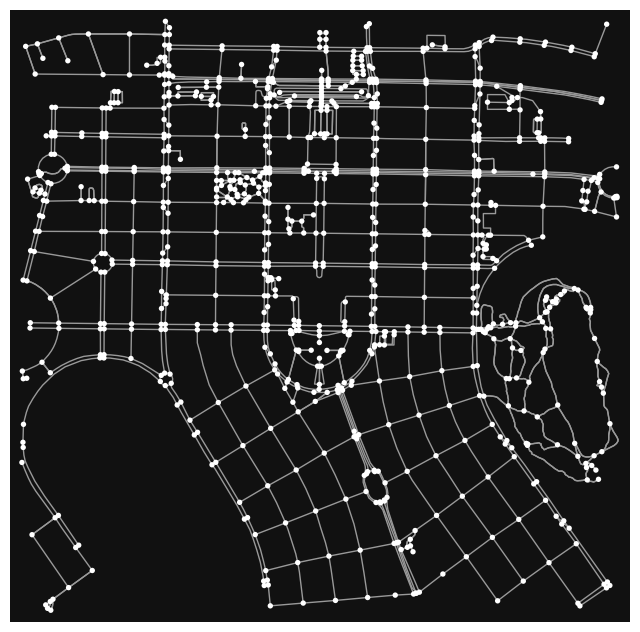

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [13]:
G = ox.graph_from_address('Maringá, Brazil')
ox.plot_graph(G)

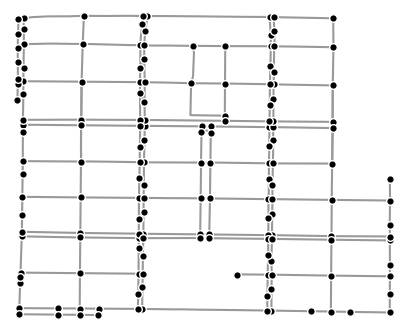

(<Figure size 500x500 with 1 Axes>, <AxesSubplot:>)

In [3]:
# desenhar o grafo
ox.plot_graph(grafo_inga, figsize=[5, 5], bgcolor='white', node_size=30, node_color='black', node_edgecolor='white', node_zorder=3, edge_color='#999999', edge_linewidth=1.5, edge_alpha=1)

In [7]:
grafo_inga.nodes()

NodeView((900551253, 900551288, 1416810736, 1416810741, 1416810746, 1416810755, 1416810780, 1421448169, 1421448170, 1421448171, 1421448172, 1421448173, 1421448175, 1421448176, 1421448183, 1421448189, 1421448191, 1421448194, 1421448197, 1421459470, 1421459498, 1421459528, 1421459530, 1421459533, 1421459548, 1421459551, 1421459580, 1421459597, 1421459606, 1421459609, 1421459629, 1421459640, 1421459646, 1421688582, 1421688586, 1421688596, 1421688607, 1421706648, 1421706649, 1421706650, 1421706651, 1421706652, 1421706656, 1421706657, 1421706662, 1421706664, 1421706667, 1421739509, 1421739546, 1421739571, 1421739602, 1421739608, 1424929780, 1424929808, 1424929818, 1424929827, 1424929848, 1424929849, 1424929858, 1425740426, 1425740430, 1425740442, 1425740444, 1425740463, 1425740470, 1425740471, 1425740475, 1425740476, 1425740478, 1425740483, 1425740484, 1425740485, 1425773085, 1425773089, 1425773093, 1425773094, 1425773098, 1425773099, 1425773124, 1425773125, 1425773132, 1425773140, 14257731

In [8]:
# information of a node
grafo_inga.nodes[1421448173]

{'y': -23.4199185,
 'x': -51.9363323,
 'highway': 'traffic_signals',
 'street_count': 4}

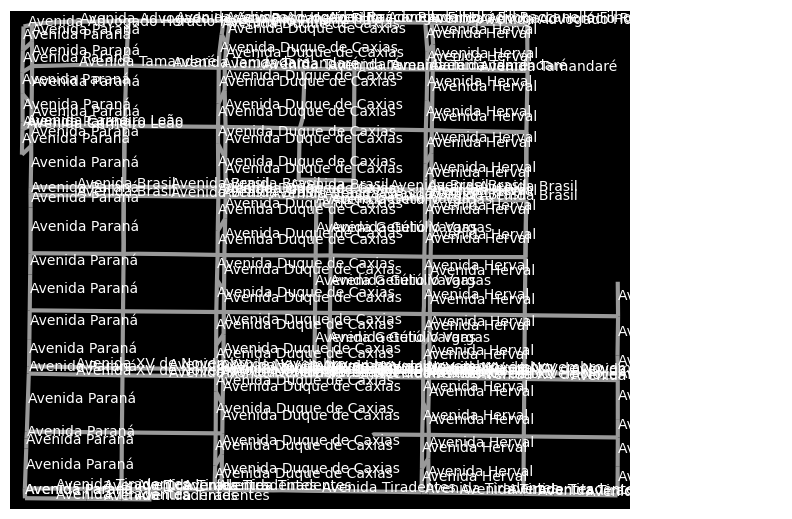

In [ ]:
# colocar nomes nas ruas
# essa função edge consigo pegar alguns dados, como o tamanho das aresta que poderão ser usados como peso
fig, ax = ox.plot_graph(grafo_inga, bgcolor='k', edge_linewidth=3, node_size=0,
                 show=False, close=False)
for _, edge in ox.graph_to_gdfs(grafo_inga, nodes=False).fillna('').iterrows():
    # print(edge)
    # print('+++++++*10')
    if 'Avenida' in edge['name']:
        c = edge['geometry'].centroid
        text = edge['name']
        ax.annotate(text, (c.x, c.y), c='w')
plt.show()

# DataFrame
a biblioteca osmnx gera uma matriz com as coordenadas de cada nó do grafo, velocidade da via, nível da via e outros dados. Dessa matriz filtrei os dados que me interessam que são, os nós, seus vizinhos e as distâncias entre eles. 

In [41]:
# passei a matriz de adjacência para um dataframe
df = pd.DataFrame(ox.graph_to_gdfs(grafo_inga, nodes=False))

In [42]:
# extração dos nós e distâncias entre eles
dff = pd.DataFrame(df['length']).reset_index()

In [43]:
# exclui coluna que não seria necessária
dff.drop(['key'], axis=1, inplace=True)

In [ ]:
dff

# A*
Algoritmo A* é um algoritmo de busca que utiliza uma heurística para encontrar o caminho mais curto entre dois pontos. Esse algoritmo usa uma funcção que é a soma da função custo e da heurística. A função custo é a distância percorrida pelo grafo do início até aquele determinado ponto. A heurística é a distância entre o ponto atual e o ponto final. A soma dessas duas funções é o valor que o algoritmo utiliza para escolher o próximo ponto a ser visitado.

In [7]:
from vertice import Vertice

In [69]:
# distancia em linha reta do vértice atual ao vértice fim
def heuristica(u, v):
    return ox.distance.great_circle_vec(grafo_inga.nodes[u]['x'], grafo_inga.nodes[u]['y'], grafo_inga.nodes[v]['x'], grafo_inga.nodes[v]['y'], earth_radius=6371009)

In [70]:
# distancia entre dois vertices
def custo(u, v):
    return u.getCusto() + dff[(dff['u'] == u.getIdNo()) & (dff['v'] == v)]['length'].tolist()[0]

In [71]:
def recuperarCaminho(arvore):

    caminho = []
    caminho.append(arvore[-1].getIdNo())

    pai = arvore[-1].getPai()
    cont = len(arvore) - 1

    bool = True
    while bool:
        if arvore[cont].getIdNo() == pai:
            caminho.append(arvore[cont].getIdNo())
            pai = arvore[cont].getPai()
        
        if pai == None:
            bool = False

        cont -= 1

    return caminho[::-1]

In [72]:
def mostrarCaminho(caminho):
    ox.plot.plot_graph_route(grafo_inga, caminho)

In [73]:
def buscaAestrela(grafo, inicio, fim):
    ordenarPeloCusto = lambda encontrarVizinhos: encontrarVizinhos.sort(key=lambda x: x.getCusto() + x.getHeuristica())
    encontrarVizinhos = []
    arvore = []

    encontrarVizinhos.append(Vertice(inicio, None, 0, heuristica(inicio, fim)))

    while encontrarVizinhos != [] and (arvore[-1].getIdNo() != fim if arvore != [] else True):
        atual = encontrarVizinhos.pop(0)
        arvore.append(atual)

        for i in grafo_inga.adj[atual.getIdNo()]:
            encontrarVizinhos.append(Vertice(i, atual.getIdNo(), custo(atual, i), heuristica(i, fim)))

        ordenarPeloCusto(encontrarVizinhos)

    if encontrarVizinhos == []:
        print(f'\n\nnó {fim} não encontrado\n\n')

    return arvore

In [74]:
# inicio - 900551253
# fim - 8794056279

arvore = buscaAestrela(grafo_inga, 900551253, 8794056279)

# Visualizar rota

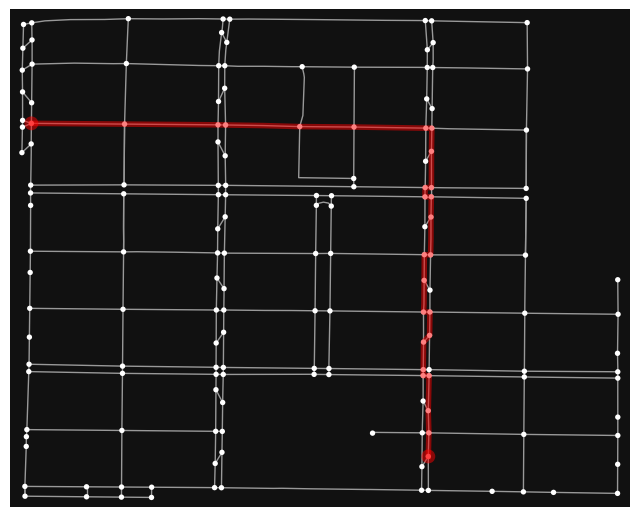

In [75]:
caminho = recuperarCaminho(arvore)
mostrarCaminho(caminho)